1. Wczytuję bazę danych dotyczącą śmiertelnych interwencji policji w USA- wczytuję ją do obiektu DataFrame

In [24]:
import pandas as pd
df = pd.read_csv('fatal-police-shootings-data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


2.Przekształcam tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’)Zrobię to przy pomocy grupowania danych 


In [26]:
race_mental_illness_counts = df.groupby(['race', 'signs_of_mental_illness']).size().reset_index(name='count')
print(race_mental_illness_counts)

   race  signs_of_mental_illness  count
0     A                    False     69
1     A                     True     24
2     B                    False   1114
3     B                     True    184
4     H                    False    745
5     H                     True    157
6     N                    False     64
7     N                     True     14
8     O                    False     37
9     O                     True     11
10    W                    False   1763
11    W                     True    713


3.Za pomocą Apply dodaje do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiadam na pytanie : która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.

In [32]:
percent_mental_illness = (
    df.groupby('race')['signs_of_mental_illness']
    .apply(lambda x: x.mean() * 100)
)
df['percent_mental_illness'] = df['race'].map(percent_mental_illness)
print(df[['race', 'signs_of_mental_illness', 'percent_mental_illness']].drop_duplicates())
highest_percentage = percent_mental_illness.idxmax()
highest_value = percent_mental_illness.max()
print(f"Rasa z największym odsetkiem przypadków z oznakami choroby psychicznej to {highest_percentage} z odsetkiem {highest_value:.2f}%.")


    race  signs_of_mental_illness  percent_mental_illness
0      A                     True               25.806452
1      W                    False               28.796446
2      H                    False               17.405765
3      W                     True               28.796446
9      B                    False               14.175655
12     B                     True               14.175655
35     H                     True               17.405765
38     O                    False               22.916667
59   NaN                    False                     NaN
65     N                    False               17.948718
153    A                    False               25.806452
295    N                     True               17.948718
327    O                     True               22.916667
340  NaN                     True                     NaN
Rasa z największym odsetkiem przypadków z oznakami choroby psychicznej to W z odsetkiem 28.80%.


4.Dodaje kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zliczam interwencje według odpowiedniego dnia tygodnia. Następnie tworzę wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.


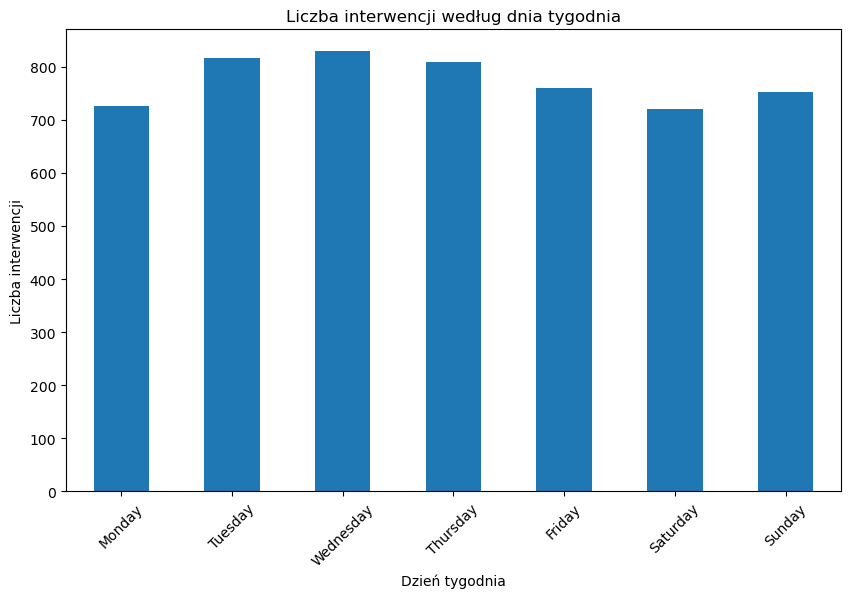

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['day_of_week'] = df['date'].dt.day_name()
day_counts = df['day_of_week'].value_counts()
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(ordered_days)

plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar')
plt.title("Liczba interwencji według dnia tygodnia")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Liczba interwencji")
plt.xticks(rotation=45)
plt.show()


5.Wczytuje do projektu dane, dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Łącze te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.

In [36]:
import pandas as pd

abbreviation_url = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'
abbreviation_tables = pd.read_html(abbreviation_url)
abbreviation_data = abbreviation_tables[1]

abbreviation_data = abbreviation_data[['Name', 'USPS']]
abbreviation_data.columns = ['state', 'abbreviation']

population_url = 'https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population'
population_tables = pd.read_html(population_url)
population_data = population_tables[0] 

population_data = population_data[['State', 'Census population, April 1, 2020 [1][2]']]
population_data.columns = ['state', 'population'] 

population_data.loc[:, 'state'] = population_data['state'].str.strip()

merged_data = pd.merge(population_data, abbreviation_data, on='state', how='inner')

shootings_data = pd.read_csv("fatal-police-shootings-data.csv")
incident_counts = shootings_data['state'].value_counts().reset_index()
incident_counts.columns = ['abbreviation', 'incident_count']

final_data = pd.merge(incident_counts, merged_data, on='abbreviation', how='left')
final_data['incidents_per_1000'] = (final_data['incident_count'] / final_data['population']) * 1000

print(final_data[['state', 'abbreviation', 'population', 'incident_count', 'incidents_per_1000']])


                   state abbreviation  population  incident_count  \
0             California           CA    39538223             799   
1                  Texas           TX    30145505             481   
2                Florida           FL    21538187             350   
3                Arizona           AZ     7151502             254   
4               Colorado           CO     5773714             195   
5                Georgia           GA    10711908             182   
6               Oklahoma           OK     3959353             164   
7         North Carolina           NC    10439388             156   
8                   Ohio           OH    11799448             155   
9             Washington           WA     7705281             152   
10              Missouri           MO     6154913             141   
11             Tennessee           TN     6910840             139   
12             Louisiana           LA     4657757             109   
13          Pennsylvania          